# Plotting cycle to work times

In [1]:
#!pip install HASS-data-detective # Install detective

In [2]:
!pip show HASS-data-detective

Name: HASS-data-detective
Version: 2.4
Summary: Tools for studying Home Assistant data.
Home-page: https://github.com/robmarkcole/HASS-data-detective
Author: Robin Cole
Author-email: robmarkcole@gmail.com
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: pandas, pytz, ruamel.yaml, SQLAlchemy
Required-by: 


In [3]:
import detective.core as detective
import detective.functions as functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db = detective.db_from_hass_config()

YAML tag !include_dir_merge_list is not supported
YAML tag !include_dir_merge_named is not supported
Successfully connected to database sqlite:////config/home-assistant_v2.db
There are 305 entities with data


First we extract all state changes for Gaby and Charles

In [14]:
people = ("person.charles","person.gaby",)
workplaces = ("Imperial", "Harris Westminster",)

In [15]:
results = db.fetch_all_data_of(people)
results.last_changed = pd.to_datetime(results.last_changed)
results.set_index('last_changed', inplace=True)
results.index.rename("time", inplace=True)
results.sort_index(inplace=True)
results

The returned Pandas dataframe has 35210 rows of data.


,domain,entity_id,state,attributes
time,,,,
2021-11-29 17:46:13.769858,person,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.41..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.42..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.43..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.46..."
...,...,...,...,...
2022-03-10 17:38:54.519291,person,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-03-10 21:37:55.362291,person,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-03-10 21:37:55.362291,person,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."


Person states have a lot of duplicates due to their attributes. Drop these, and use the times as the index:

In [16]:
results['time'] = results.index
results = results.drop_duplicates(subset=('domain', 'entity_id', 'state', 'time')).drop(['time', 'attributes'], axis=1)
results

,domain,entity_id,state
time,,,
2021-11-29 17:46:13.769858,person,person.gaby,home
2021-11-30 07:51:31.218973,person,person.gaby,not_home
2021-11-30 08:12:10.004068,person,person.charles,not_home
2021-11-30 08:35:23.349953,person,person.gaby,Harris Westminster
2021-11-30 09:05:18.560750,person,person.charles,Imperial
...,...,...,...
2022-03-10 17:20:04.341422,person,person.gaby,not_home
2022-03-10 17:20:04.342138,person,person.charles,home
2022-03-10 17:38:54.519291,person,person.gaby,home


For each day, if the person went to work, store their arrival & departure times

In [121]:
dates = pd.date_range(min(results.index), max(results.index), normalize=True)

arrival_times = {person: pd.Series(dtype="timedelta64[ns]") for person in people}
leaving_times = {person: pd.Series(dtype="timedelta64[ns]") for person in people}

for date in dates:
    state_changes = results[date : date + np.timedelta64(1, 'D')]
    
    for person, workplace in zip(people, workplaces):
        this_person_changes = state_changes[state_changes.entity_id == person]
        if any(this_person_changes.state == workplace):
            workplace_states = this_person_changes[this_person_changes.state == workplace]
            arrival_times[person][date] = min(workplace_states.index) - date
            leaving_times[person][date] = max(workplace_states.index) - date
            
arrival_times = pd.DataFrame(arrival_times)
leaving_times = pd.DataFrame(leaving_times)

In [122]:
times = pd.concat([
    arrival_times.rename(columns={person: person + " leaving" for person in people}),
    leaving_times.rename(columns={person: person + " leaving" for person in people})
] , axis=1)

array([    0, 10000, 20000, 30000, 40000], dtype=timedelta64)

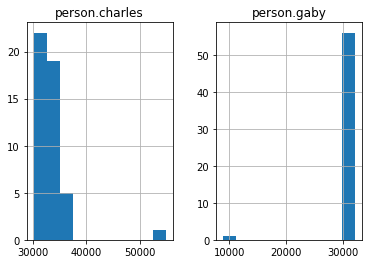

In [134]:
import matplotlib.pyplot as plt

(arrival_times/np.timedelta64(1, 's')).hist()
times, _ = plt.xticks()
times.astype(np.timedelta64)

<AxesSubplot:>

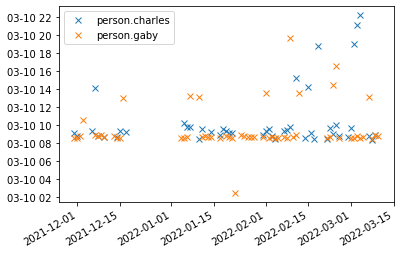

In [110]:
leaving_times.plot(style='x')